## Diagnose inflow angle of K01 and K25 by comparing with Ku-band scatterometers

NB: Zhang and Uhlhorn 2012 have a RMSE of about 14 degrees for their parametric model (12 degrees when they take a pre-filtered subsample) in terms of inflow angle (see their Fig. 16 and text).

NB: There is an impact of center uncertainty on the scatterometer inflow angle estimates (see e.g Zhang and Uhlhorn 2012 for orders of magnitude). In the scatterometer polar netcdf files, the (lon, lat) coordinates of the center come from interpolated best-tracks in section (2), so the storm motion shouldn't have any effect on my results. To check that, in section (3) I also computed the polar scatterometer files based on the SAR center estimates, adjusted for storm motion, and compared the inflow angle based on those. Results are nearly identical.  

<u>Conclusions:</u> Les modèles PRM sont meilleurs que les modèles FIT d'environ 2 degrés. La situation n'est pas si claire que ça entre 1 et 2 Rmax (jouer avec le paramètre dt); mais bon il vaut quand même mieux utiliser les modèles PRM. K25_PRM performs slightly better than K01_PRM in terms of inflow_angle.

TODO: Refaire tourner les plots une fois que FIT_K25 a fini de tourner.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from pyproj import Geod, CRS

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K01_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
    'K25_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/cases/',
}

PRMS = {
    'dt': 90, # Delta time used for collocation, in min
}

### Open data
# SAR
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &

    (dsg.dist2coast  > dsg.r34)             & # Distance to coast
    (dsg.percent_outside < 10)              & # Sufficient SAR coverage
    # (dkg01.vmx > 20)                            & # Test
    # (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    # (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    # (dkg01.asym_avg_err  <= 2.5)                & # Test
    # (dkg01.phase_avg_err <= 45)                 & # Test
    # (~xr.where(dkg01.non_C1 == 0, False, True)) & # Ensure that I > V/r
    ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

117


### 1) Collocate SAR and HY-2

In [4]:
# For debug, use t = 90

# Initialize
list_of_collocated_sct_pths = []
list_of_collocated_sar_fles = []

# Iterate
for t in tqdm(range(len(dsg_filtered.time))):
    ### Open SAR
    ds         = dsg_filtered.isel(time=t)

    ### Collocate eventual SCAT data
    # Extract SCAT data from that previous, current, and next day
    year = ds.time.data.astype('datetime64[Y]').astype(int) + 1970 # Year of the current ibt_time
    days = int((ds.time - np.datetime64('{}-01-01'.format(year))) / np.timedelta64(1, 'D')) + 1 # Nb of days since beginning of that year
    # Take previous, current and next day (note that this doesn't cover the beginning or end of a year, in the unlikely occurrence)
    sct_data_crt = np.array(
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days - 1)) +  
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days))     + 
        glob.glob(PTHS['sct_dir'] + 'polar/*/{}/'.format(year) + '{0:03}/*.nc'.format(days + 1))
    )
    # Paths that have the correct ATCF ID
    matching_paths = []
    for path in sct_data_crt:
        filename = os.path.basename(path) 
        if filename.endswith(f"{ds.id.item()}.nc"):
            matching_paths.append(path)
    # Collocated paths
    for matching_path in matching_paths:
        # Open
        ds_matching = xr.open_dataset(matching_path)
        # If collocated, append
        if abs(ds.time - ds_matching.time) < np.timedelta64(PRMS['dt'], 'm'):
            list_of_collocated_sct_pths.append(matching_path)
            list_of_collocated_sar_fles.append(ds.file_tcva.item())
        # Close
        ds_matching.close()
    # Close
    ds.close()
    ### Open models
    # dsp        = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    # dsk_prm    = xr.open_dataset(PTHS['K01_PRM_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10, theta=slice(0, 359))
    # dsk_fit    = xr.open_dataset(PTHS['K01_FIT_dir'] + ds.file_tcva.item()[:-17] + '.nc').sel(z=10).interp(theta=np.array(dsp.theta))

print(len(list_of_collocated_sct_pths))

  0%|          | 0/117 [00:00<?, ?it/s]

79


In [5]:
# Check for duplicates
has_duplicates = len(list_of_collocated_sar_fles) != len(set(list_of_collocated_sar_fles))
if has_duplicates:
    print("La liste contient des doublons.")
else:
    print("La liste ne contient pas de doublons.")

La liste contient des doublons.


### 2) Compare average inflow angles based on raw files

#### r-grid

In [6]:
### Open data
# SCAT
dsc_sct = xr.open_mfdataset(list_of_collocated_sct_pths, combine='nested', concat_dim='idx')
# K01 PRM
dsk01p  = xr.open_mfdataset([PTHS['K01_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K01 FIT
dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 PRM
dsk25p  = xr.open_mfdataset([PTHS['K25_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 FIT
dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

### Optional
# K01 wIA
dsk01i  = xr.open_mfdataset([PTHS['K01_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 wIA
dsk25i  = xr.open_mfdataset([PTHS['K25_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

In [7]:
# # Eventually put on a high-resolution grid
# # doesn't bring anything
# r_ref   = np.linspace(0, 500000, int((500 // 1) + 1))
# t_ref   = np.linspace(0, 360, 361)
# dsc_sct = dsc_sct.interp(rad=r_ref, theta=t_ref)

In [8]:
### Compute inflow angle differences
iadk01p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

### Optinal
iadk01i = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01i.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25i = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25i.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

(0.0, 250000.0)

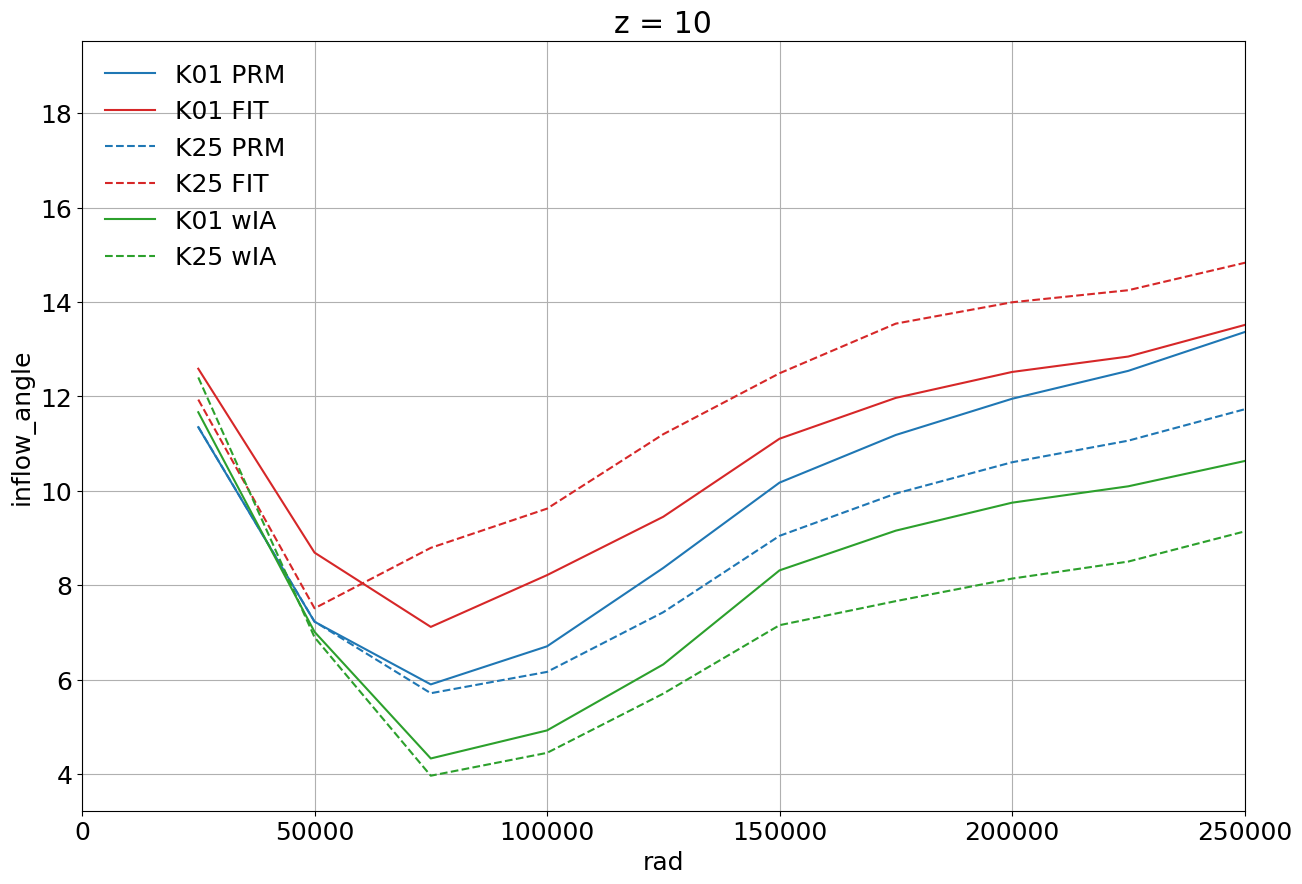

In [9]:
# Plot
abs(iadk01p).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')

# Optional
abs(iadk01i).mean(dim='idx', skipna=True).plot(label='K01 wIA', c='tab:green')
abs(iadk25i).mean(dim='idx', skipna=True).plot(label='K25 wIA', c='tab:green',  linestyle='dashed')

# Grids
plt.grid()
plt.legend(frameon=False)
plt.xlim(0, 250000)

#### r*-grid

In [10]:
# r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)

In [11]:
# dsg_filtered.where(dsg_filtered.file_tcva.isin(list_of_collocated_sar_fles), drop=True)

# # Collocated SAR winds
# dsc_sar = xr.open_mfdataset([PTHS['sar_dir'] + path for path in list_of_collocated_sar_fles])

In [12]:
# 1st loop to determine all the rmax values
RMXS = []
for idx, file_tcva in tqdm(enumerate(list_of_collocated_sar_fles)):
    ### Open SAR
    ds         = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva, drop=True)
    # Append
    RMXS.append(float(ds.rmx))
    # # Close
    # ds.close()

0it [00:00, ?it/s]

In [13]:
# Replace r by r / Rmax
for dddddd in [dsc_sct, dsk01p, dsk01f, dsk25p, dsk25f]:
    dddddd['rad'] = dddddd['rad'].expand_dims(idx=dddddd['idx']) / xr.DataArray(RMXS, coords={'idx': dddddd.idx}, dims=('idx',))

# Optional
# Replace r by r / Rmax
for dddddd in [dsk01i, dsk25i]:
    dddddd['rad'] = dddddd['rad'].expand_dims(idx=dddddd['idx']) / xr.DataArray(RMXS, coords={'idx': dddddd.idx}, dims=('idx',))

In [14]:
# 2nd loop to interpolate on r_star
l_dsc_sct_ = []
l_dsk01p_  = []
l_dsk01f_  = []
l_dsk25p_  = []
l_dsk25f_  = []

# Optional
l_dsk01i_  = []
l_dsk25i_  = []

for idx in tqdm(range(len(list_of_collocated_sar_fles))):
    l_dsc_sct_.append(dsc_sct.isel(idx=idx).interp(rad=r_star))
    l_dsk01p_.append(dsk01p.isel(idx=idx).interp(rad=r_star))
    l_dsk01f_.append(dsk01f.isel(idx=idx).interp(rad=r_star))
    l_dsk25p_.append(dsk25p.isel(idx=idx).interp(rad=r_star))
    l_dsk25f_.append(dsk25f.isel(idx=idx).interp(rad=r_star))

    # Optional
    l_dsk01i_.append(dsk01i.isel(idx=idx).interp(rad=r_star))
    l_dsk25i_.append(dsk25i.isel(idx=idx).interp(rad=r_star))

dsc_sct_ = xr.concat(l_dsc_sct_, dim='idx')
dsk01p_  = xr.concat(l_dsk01p_,  dim='idx')
dsk01f_  = xr.concat(l_dsk01f_,  dim='idx')
dsk25p_  = xr.concat(l_dsk25p_,  dim='idx')
dsk25f_  = xr.concat(l_dsk25f_,  dim='idx')

# Optional
dsk01i_  = xr.concat(l_dsk01i_,  dim='idx')
dsk25i_  = xr.concat(l_dsk25i_,  dim='idx')

  0%|          | 0/79 [00:00<?, ?it/s]

In [15]:
### Compute inflow angle differences
iadk01p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

# Optional
iadk01i_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01i_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25i_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25i_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

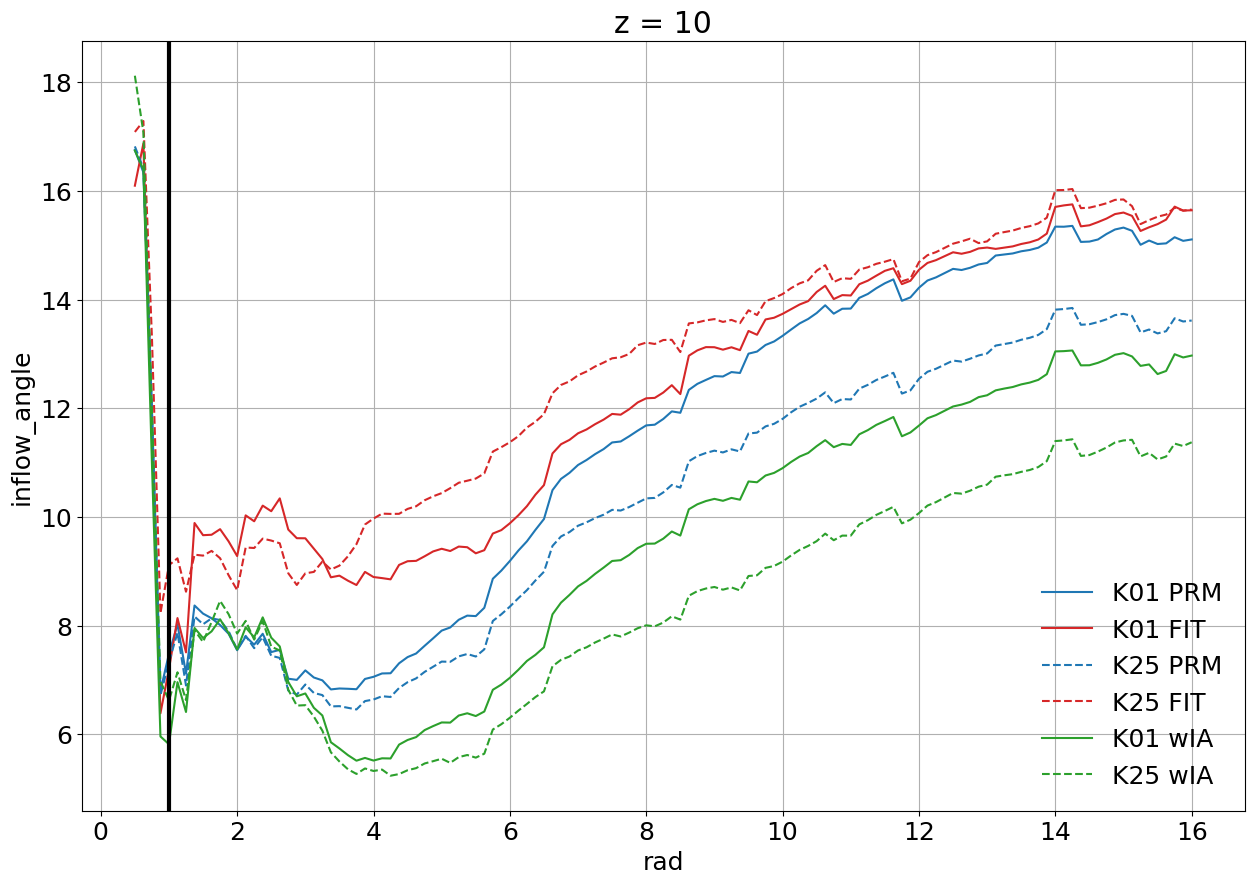

In [16]:
# Plot
abs(iadk01p_).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f_).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p_).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f_).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')

# Optional
abs(iadk01i_).mean(dim='idx', skipna=True).plot(label='K01 wIA', c='tab:green')
abs(iadk25i_).mean(dim='idx', skipna=True).plot(label='K25 wIA', c='tab:green',  linestyle='dashed')

# Grid
plt.grid()
plt.legend(frameon=False)
plt.axvline(1, c='k', linewidth=3)
# plt.xlim(0, 250000)

In [17]:
### Close
dsc_sct.close(),  dsk01p.close(),  dsk01f.close(),  dsk25p.close(),  dsk25f.close()
dsc_sct_.close(), dsk01p_.close(), dsk01f_.close(), dsk25p_.close(), dsk25f_.close()

# Optional
dsk01i.close(), dsk25i.close()
dsk01i_.close(), dsk25i_.close()

(None, None)

### 3) Compare average inflow angles based on SAR centers

In [18]:
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

# Polar
r_ref        = np.linspace(0, 500, int((500 // 25) + 1))
t_ref        = np.linspace(0, 360, int((360 // 4)  + 1))
r_grd, t_grd = np.meshgrid(r_ref, t_ref)

In [19]:
# Initialize Geod
geod     = Geod(ellps='WGS84')

# Root dir
root_dir = '/home/arthur/results/scatterometry/hy-2/01_collocate_TC_HY2/'

In [20]:
# Initialize
list_of_adjusted_scats = []

# Loop to adjust for storm motion
for idx, (file_tcva, file_sct) in tqdm(enumerate(zip(list_of_collocated_sar_fles, list_of_collocated_sct_pths))):
    # Open
    ds_sar = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva, drop=True)
    ds_sct = xr.open_dataset(file_sct)
    # Compute SAR center new coordinates after storm motion
    time_diff = (ds_sct.time - ds_sar.time).astype(float) / 1_000_000_000 # seconds
    distance  = float(ds_sar.storm_speed_ibt * time_diff) # meters
    new_lon, new_lat, _ = geod.fwd(
        float(ds_sar.lon),
        float(ds_sar.lat),
        float(ds_sar.storm_dir_ibt),
        distance
    )
    # Open initial scat
    filename = os.path.basename(file_sct)[4:-3]
    raw_sct  = xr.open_dataset(root_dir + '/'.join(file_sct.split('/')[8:11]) + '/{}.nc'.format(filename))
    # Filter NaN values in the coordinates
    raw_sct                    = raw_sct.dropna(dim='NUMCELLS', how='any', subset=['lon', 'lat'])
    
    lons                       = np.array(raw_sct.lon)
    lats                       = np.array(raw_sct.lat)
    
    lons_center                = np.ones_like(lons) * new_lon
    lats_center                = np.ones_like(lats) * new_lat
    
    geod_wgs84                 = CRS("epsg:4326").get_geod()
    forward_az, _, dr          = geod_wgs84.inv(lons_center, lats_center, lons, lats)
    
    forward_az                 = forward_az - float(ds_sar.storm_dir_ibt) + 90 # I have to add 90° because in Cyclobs TCs are moving to the right!
    raw_sct['wind_dir']        = raw_sct['wind_dir'] - float(ds_sar.storm_dir_ibt) + 90 # Same
    
    th                         = get_polar_theta(forward_az) # r is dr
    
    raw_sct['radial_wind']     = raw_sct.wind_speed * np.sin(np.deg2rad(raw_sct.wind_dir + th))
    raw_sct['tangential_wind'] = raw_sct.wind_speed * np.cos(np.deg2rad(raw_sct.wind_dir + th))
    
    #################
    ###   POLAR   ###
    #################
    # Interpolate on reference grid
    ws_pol       = griddata((dr.flatten() / 1000, th.flatten()), np.array(raw_sct.wind_speed).flatten(),      (r_grd, t_grd), method='linear')
    u_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(raw_sct.radial_wind).flatten(),     (r_grd, t_grd), method='linear')
    v_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(raw_sct.tangential_wind).flatten(), (r_grd, t_grd), method='linear')
    
    # Create xr.Dataset
    ds_pol_SCT = xr.Dataset(
        data_vars={
            'idx':             ([], idx),
            'wind_speed':      (['theta', 'rad'], ws_pol),
            'radial_wind':     (['theta', 'rad'], u_pol),
            'tangential_wind': (['theta', 'rad'], v_pol),
        },
        coords={
            'theta': t_ref,
            'rad':   r_ref * 1000
        } 
    )
    
    # Filter the 0 m/s values
    ds_pol_SCT['wind_speed']   = xr.where(ds_pol_SCT['wind_speed'] > 0, ds_pol_SCT['wind_speed'], np.nan)
    # Inflow angle
    ds_pol_SCT['inflow_angle'] = np.rad2deg(np.arctan(ds_pol_SCT.radial_wind / ds_pol_SCT.tangential_wind))

    # Append
    list_of_adjusted_scats.append(ds_pol_SCT)
    
    # Close
    ds_sct.close()
    raw_sct.close()

0it [00:00, ?it/s]

#### r-grid

In [21]:
### Open data
# SCAT
# dsc_sct = xr.open_mfdataset(list_of_collocated_sct_pths, combine='nested', concat_dim='idx')
dsc_sct = xr.concat(list_of_adjusted_scats, dim='idx')
# K01 PRM
dsk01p  = xr.open_mfdataset([PTHS['K01_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K01 FIT
dsk01f  = xr.open_mfdataset([PTHS['K01_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 PRM
dsk25p  = xr.open_mfdataset([PTHS['K25_PRM_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 FIT
dsk25f  = xr.open_mfdataset([PTHS['K25_FIT_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

### Optional
# K01 wIA
dsk01i  = xr.open_mfdataset([PTHS['K01_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')
# K25 wIA
dsk25i  = xr.open_mfdataset([PTHS['K25_wIA_dir'] + '{}.nc'.format(path[:-17]) for path in list_of_collocated_sar_fles], combine='nested', concat_dim='idx')

/home/arthur/anaconda3/envs/dataBasics/lib/python3.13/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension idx because variable idx is not a coordinate. To create an index for idx, please first call `.set_coords('idx')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


In [22]:
### Compute inflow angle differences
iadk01p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25p.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25f.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

# Optional
iadk01i = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk01i.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25i = dsc_sct.inflow_angle.mean(dim='theta', skipna=True) - dsk25i.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

(0.0, 250000.0)

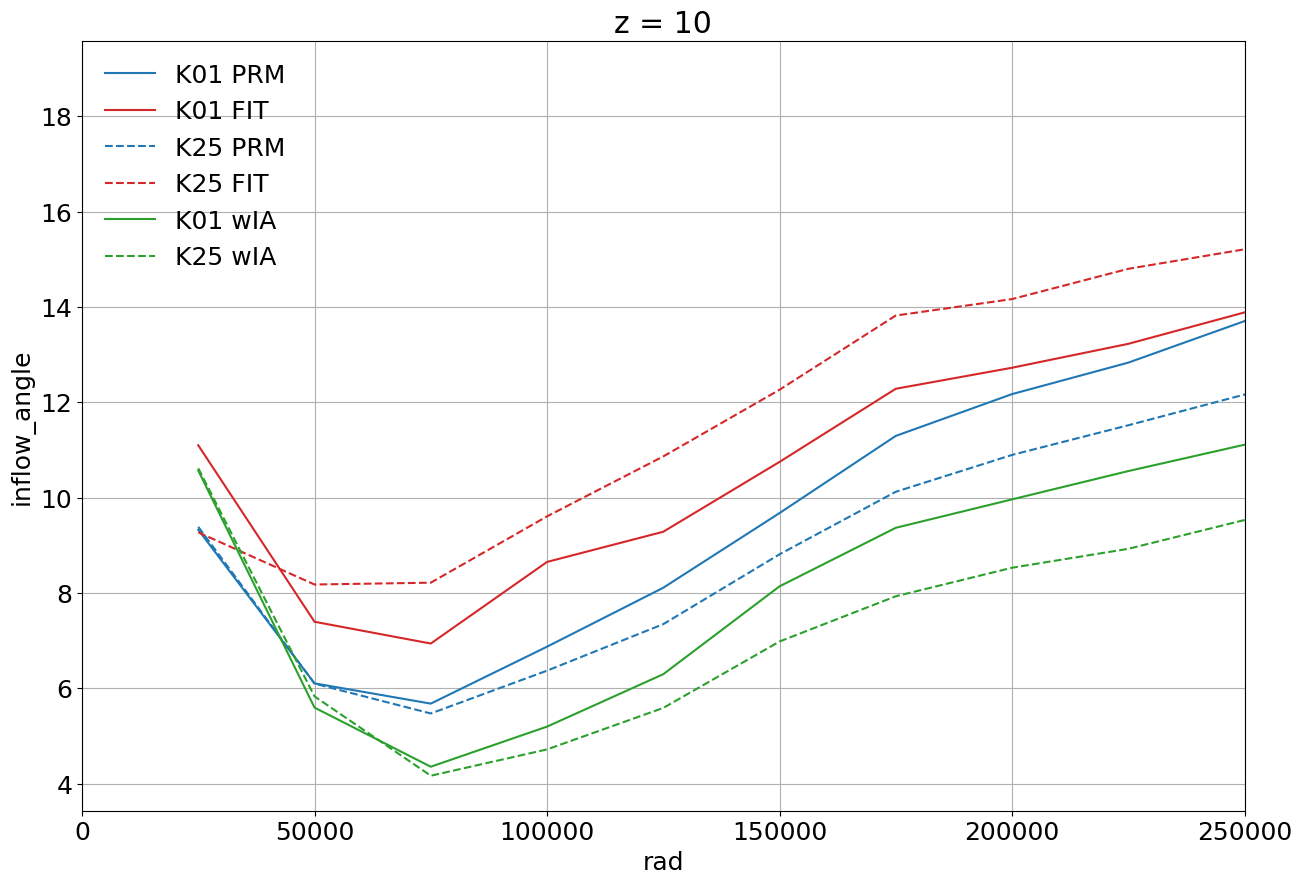

In [23]:
# Plot
abs(iadk01p).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')

# Optional
abs(iadk01i).mean(dim='idx', skipna=True).plot(label='K01 wIA', c='tab:green')
abs(iadk25i).mean(dim='idx', skipna=True).plot(label='K25 wIA', c='tab:green',  linestyle='dashed')

# Grid
plt.grid()
plt.legend(frameon=False)
plt.xlim(0, 250000)

#### r*-grid

In [24]:
# 1st loop to determine all the rmax values
RMXS = []
for idx, file_tcva in tqdm(enumerate(list_of_collocated_sar_fles)):
    ### Open SAR
    ds         = dsg_filtered.where(dsg_filtered.file_tcva == file_tcva, drop=True)
    # Append
    RMXS.append(float(ds.rmx))
    # # Close
    # ds.close()

0it [00:00, ?it/s]

In [25]:
# Replace r by r / Rmax
for dddddd in [dsc_sct, dsk01p, dsk01f, dsk25p, dsk25f]:
    dddddd['rad'] = dddddd['rad'].expand_dims(idx=dddddd['idx']) / xr.DataArray(RMXS, coords={'idx': dddddd.idx}, dims=('idx',))

# Optional
# Replace r by r / Rmax
for dddddd in [dsk01i, dsk25i]:
    dddddd['rad'] = dddddd['rad'].expand_dims(idx=dddddd['idx']) / xr.DataArray(RMXS, coords={'idx': dddddd.idx}, dims=('idx',))

In [26]:
# 2nd loop to interpolate on r_star
l_dsc_sct_ = []
l_dsk01p_  = []
l_dsk01f_  = []
l_dsk25p_  = []
l_dsk25f_  = []

# Optional
l_dsk01i_  = []
l_dsk25i_  = []

for idx in tqdm(range(len(list_of_collocated_sar_fles))):
    l_dsc_sct_.append(dsc_sct.isel(idx=idx).interp(rad=r_star))
    l_dsk01p_.append(dsk01p.isel(idx=idx).interp(rad=r_star))
    l_dsk01f_.append(dsk01f.isel(idx=idx).interp(rad=r_star))
    l_dsk25p_.append(dsk25p.isel(idx=idx).interp(rad=r_star))
    l_dsk25f_.append(dsk25f.isel(idx=idx).interp(rad=r_star))

    # Optional
    l_dsk01i_.append(dsk01i.isel(idx=idx).interp(rad=r_star))
    l_dsk25i_.append(dsk25i.isel(idx=idx).interp(rad=r_star))

dsc_sct_ = xr.concat(l_dsc_sct_, dim='idx')
dsk01p_  = xr.concat(l_dsk01p_,  dim='idx')
dsk01f_  = xr.concat(l_dsk01f_,  dim='idx')
dsk25p_  = xr.concat(l_dsk25p_,  dim='idx')
dsk25f_  = xr.concat(l_dsk25f_,  dim='idx')

# Optional
dsk01i_  = xr.concat(l_dsk01i_,  dim='idx')
dsk25i_  = xr.concat(l_dsk25i_,  dim='idx')

  0%|          | 0/79 [00:00<?, ?it/s]

In [27]:
### Compute inflow angle differences
iadk01p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk01f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25p_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25p_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25f_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25f_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

# Optional
iadk01i_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk01i_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 
iadk25i_ = dsc_sct_.inflow_angle.mean(dim='theta', skipna=True) - dsk25i_.sel(z=10).inflow_angle.mean(dim='theta', skipna=True) 

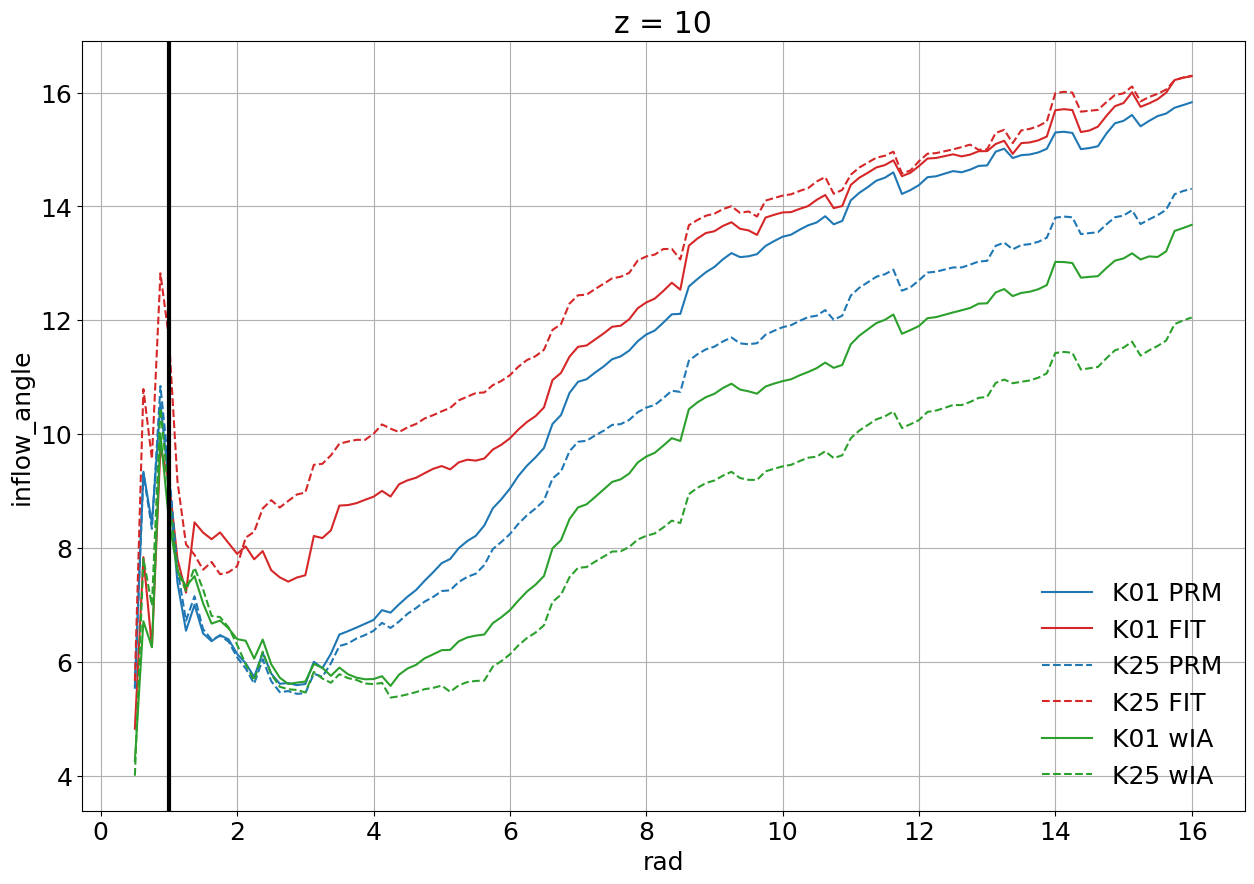

In [28]:
# Plot
abs(iadk01p_).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
abs(iadk01f_).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
abs(iadk25p_).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
abs(iadk25f_).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')

# Optional
abs(iadk01i_).mean(dim='idx', skipna=True).plot(label='K01 wIA', c='tab:green')
abs(iadk25i_).mean(dim='idx', skipna=True).plot(label='K25 wIA', c='tab:green',  linestyle='dashed')

# Grid
plt.grid()
plt.legend(frameon=False)
plt.axvline(1, c='k', linewidth=3)
# plt.xlim(0, 250000)

In [29]:
# # Plot
# abs(iadk01p_).mean(dim='idx', skipna=True).plot(label='K01 PRM', c='tab:blue')
# abs(iadk01f_).mean(dim='idx', skipna=True).plot(label='K01 FIT', c='tab:red')
# abs(iadk25p_).mean(dim='idx', skipna=True).plot(label='K25 PRM', c='tab:blue', linestyle='dashed')
# abs(iadk25f_).mean(dim='idx', skipna=True).plot(label='K25 FIT', c='tab:red',  linestyle='dashed')
# plt.grid()
# plt.legend(frameon=False)
# plt.axvline(1, c='k', linewidth=3)
# # plt.xlim(0, 250000)